In [49]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import patches

import os
import numpy as np
import matplotlib.pyplot as plt

In [50]:
#%matplotlib widget
%matplotlib inline
# interactive, unlike 'inline'

plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})

In [51]:
parent_dir = '../data/fits/'

In [52]:
ep2_names = os.listdir(parent_dir + 'epoch2/')

ep1_names = os.listdir(parent_dir + 'epoch1/')
#[s.replace('.clean.image', '').replace('_chans16~70.fits', '')[9:] for s in ep2_names]
print(ep1_names)

['WHya_SiO_v7.clean.imcontsub.image.fits', 'old_extracts', 'WHya_29SiO_v5.clean.imcontsub.image.fits', 'WHya_29SiO_v5.clean.image.fits', 'WHya_SiO_v2_larger_mask.clean.imcontsub.image.fits', 'WHya_H2O.clean.imcontsub.image.fits', 'WHya_CO_v-1.clean.imcontsub.image_mom0_chans52~82.fits', 'WHya_SiO_v2_larger_mask.clean.imcontsub.image_mom0_chans35~86.fits', 'WHya_13CO_J3-2.clean.image.fits', 'WHya_H2O.clean.imcontsub.image_mom0_chans51~84.fits', 'WHya_SiO_v7.clean.imcontsub.image_mom0_chans48~81.fits', 'WHya_29SiO_v5.clean.imcontsub.image_mom0_chans48~83.fits', 'WHya_continuum_epoch1.image.fits', 'WHya_CO_v-1.clean.imcontsub.image.fits', 'scp_mom_maps.list']


### Epoch 1

* WHya_29SiO_v5.clean.imcontsub.image_mom0_chans48~83.fits
* WHya_CO_v-1.clean.imcontsub.image_mom0_chans52~82.fits
* WHya_H2O.clean.imcontsub.image_mom0_chans51~84.fits
* WHya_SiO_v2_larger_mask.clean.imcontsub.image_mom0_chans35~86.fits
* WHya_SiO_v7.clean.imcontsub.image_mom0_chans48~81.fits

### Epoch 2

* WHya_ep2_12CO_v-1.clean.imcontsub.image_mom0_chans52~82.fits
* WHya_ep2_29SiO_v5.clean.imcontsub.image_mom0_chans48~83.fits
* WHya_ep2_H2O.clean.imcontsub.image_mom0_chans51~84.fits
* WHya_ep2_SiO_v-2_larger_mask.clean.imcontsub.image_mom0_chans35~86.fits
* WHya_ep2_SiO_v7.clean.imcontsub.image_mom0_chans48~81.fits

~~I need the 29SiO v=5 and SiO v=7 lines.~~
Got em

In [53]:
ep1_continuum_file = parent_dir + '/epoch1/WHya_continuum_epoch1.image.fits'
ep2_continuum_file = parent_dir + '/epoch2/WHya_continuum_epoch2_shifted.image.fits'

ep1_cont_hdu = fits.open(ep1_continuum_file)
ep1_cont_data = ep1_cont_hdu[0].data
ep2_cont_hdu = fits.open(ep2_continuum_file)
ep2_cont_data = ep2_cont_hdu[0].data

In [54]:
def plot_mom_comparison(ep1_file, ep2_file, inner_radius, outer_ap_radius, moment=0, channel_range=(16, 70)):
    """
    ep1_file: name of the 
    ep2_file: ..
    moment: 0, 1, 2 or 8
    """
    if moment != 0:
        ep1_file = ep1_file.replace('mom0', f'mom{moment}')
        ep2_file = ep2_file.replace('mom0', f'mom{moment}')
        
    line_name = ep1_file.replace('.clean.image', '').replace('_chans16~70.fits', '')[5:]
    
    hdu1 = fits.open(parent_dir + 'epoch1/' + ep1_file)
    ep1_data = hdu1[0].data
    wcs1 = WCS(hdu1[0].header)

    hdu2 = fits.open(parent_dir + 'epoch2/' + ep2_file)
    ep2_data = hdu2[0].data
    wcs2 = WCS(hdu2[0].header)
    
    print('Shape of moment 0 data', ep2_data.shape)
    
    # compute some statistics
    mean, median, std = sigma_clipped_stats(ep1_data)
    mean2, med2, std2 = sigma_clipped_stats(ep2_data)
    
    # max values, useful for normalization
    max_ep1 = np.max(ep1_data, axis=(2, 3))
    max_ep2 = np.max(ep2_data, axis=(2, 3))
    max_val = max(max_ep1, max_ep2)
    
    print(f'Epoch 1 statistics for the {line_name}. mean: {mean}, median:{median}, std:{std}')
    #fig, axes = plt.subplots(1, 2, figsize=(12,6), projection=wcs1)
    
    fig = plt.figure(figsize=(13, 6))
    axes = []
    axes.append(fig.add_subplot(1, 2, 1))#, projection=wcs1[0,0]))
    axes.append(fig.add_subplot(1, 2, 2))#, projection=wcs1[0,0]))
    
    ep1_im = axes[0].imshow(ep1_data[0, 0,], vmax=max_val, vmin=0, 
                            cmap='RdYlBu_r')
    ep2_im = axes[1].imshow(ep2_data[0, 0,], vmax=max_val, vmin=0, 
                            cmap='RdYlBu_r' )
    
    # add contours
    xx, yy = np.meshgrid(np.linspace(0, 511, 512), np.linspace(0, 511, 512))
    
    ep1_cont_norm = ep1_cont_data/np.max(ep1_cont_data, axis=(2, 3))
    ep1_cont = axes[0].contour(xx, yy, ep1_cont_norm[0, 0,], levels=np.array([0.5, 0.7, 0.9]),
                               colors=['crimson'])
    ep2_cont_norm = ep2_cont_data/np.max(ep2_cont_data, axis=(2,3))
    ep2_cont = axes[1].contour(xx, yy, ep2_cont_norm[0, 0,], colors=['crimson'],
                               levels=np.array([0.2, 0.4, 0.6, 0.8]))
    
    divider = make_axes_locatable(axes[1])
    #cax = divider.append_axes('right', size='10%', pad=0.5)
    cbar = plt.colorbar(ep1_im, ax=axes,  fraction=0.046, pad=0.04)#.ravel().tolist(), orientation='horizontal',
    #cbar.
    axes[0].set_title('Epoch 1: Nov 2015', fontsize=14)
    axes[1].set_title('Epoch 2: Nov 2017', fontsize=14)
    
    center_x, center_y = (254, 246)
    print('Drawing circular apertures around {0} of radii {1} and {2}'.format((center_x, center_y),
                                            inner_radius, outer_ap_radius))
    
    for ax in axes:
        outer_ap = patches.Circle((center_x, center_y), outer_ap_radius, ec='w', ls='--', lw=1.5, fill=False, zorder=3)
        inner_ap = patches.Circle((center_x, center_y), inner_radius, ec='w', lw=1.5, zorder=4, fill=False)
        ax.add_patch(outer_ap)
        ax.add_patch(inner_ap)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', direction='in', labelsize=14)
        ax.set_xlabel('RA offset (mas)', fontsize=14)
        ax.set_xlim(center_x - (outer_ap_radius + 10), center_x + (outer_ap_radius + 10))
        ax.set_ylim(center_y - (outer_ap_radius + 10), center_y + (outer_ap_radius + 10))
    axes[0].set_ylabel('Dec offset (mas)', fontsize=14)
    axes[1].set_ylabel('Dec offset (mas)', fontsize=14)
    plt.suptitle(line_name[:-43] + 
                         f' Moment {moment} Map', fontsize=16)
    #plt.tight_layout()
    # adjust spacing
    #print(hdu1[0].header)   
    plt.savefig('../figures/' + line_name + f'_mom{moment}.jpg', dpi=300)
    
#plt.show()
 

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Shape of moment 0 data (1, 1, 512, 512)
Epoch 1 statistics for the H2O.clean.imcontsub.image_mom0_chans51~84.fits. mean: 0.0001296750851906836, median:9.944448538590223e-05, std:0.016149673610925674
Drawing circular apertures around (254, 246) of radii 4 and 21


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Shape of moment 0 data (1, 1, 512, 512)
Epoch 1 statistics for the 29SiO_v5.clean.imcontsub.image_mom0_chans48~83.fits. mean: -4.90037418785505e-05, median:0.00012223495286889374, std:0.03575398027896881
Drawing circular apertures around (254, 246) of radii 4 and 21


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Shape of moment 0 data (1, 1, 512, 512)
Epoch 1 statistics for the SiO_v2_larger_mask.clean.imcontsub.image_mom0_chans35~86.fits. mean: 0.0006107176304794848, median:0.0005331432330422103, std:0.017604725435376167
Drawing circular apertures around (254, 246) of radii 4 and 21


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Shape of moment 0 data (1, 1, 512, 512)
Epoch 1 statistics for the SiO_v7.clean.imcontsub.image_mom0_chans48~81.fits. mean: 0.00147907342761755, median:0.0018163123168051243, std:0.08609374612569809
Drawing circular apertures around (254, 246) of radii 4 and 21


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Shape of moment 0 data (1, 1, 512, 512)
Epoch 1 statistics for the CO_v-1.clean.imcontsub.image_mom0_chans52~82.fits. mean: 0.0003214897878933698, median:0.0003251507878303528, std:0.011020823381841183
Drawing circular apertures around (254, 246) of radii 4 and 21


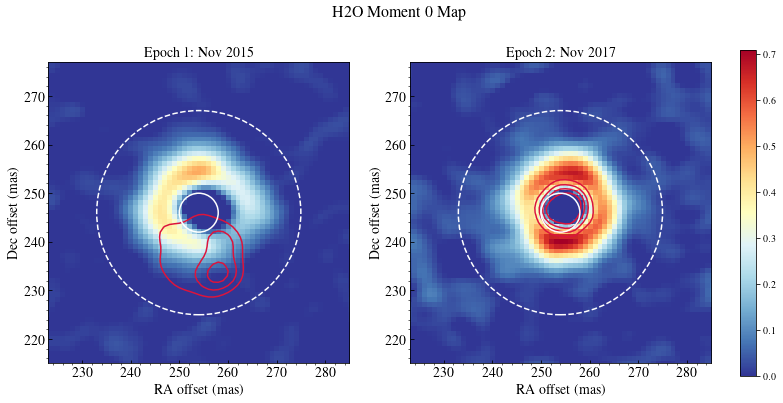

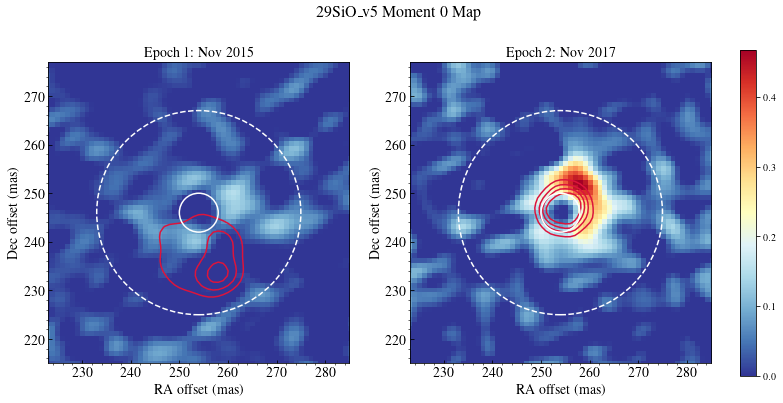

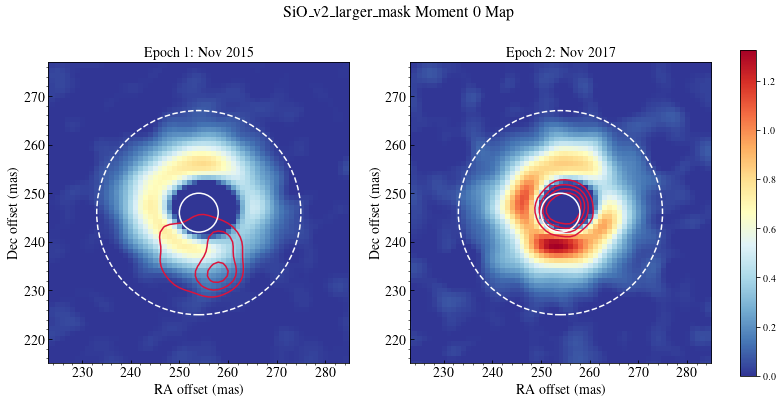

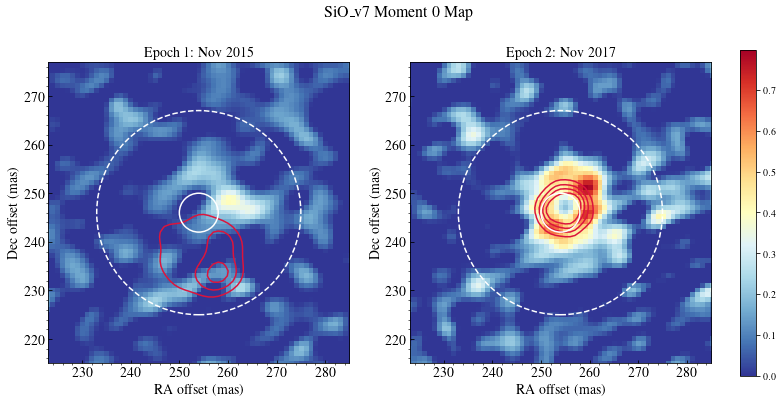

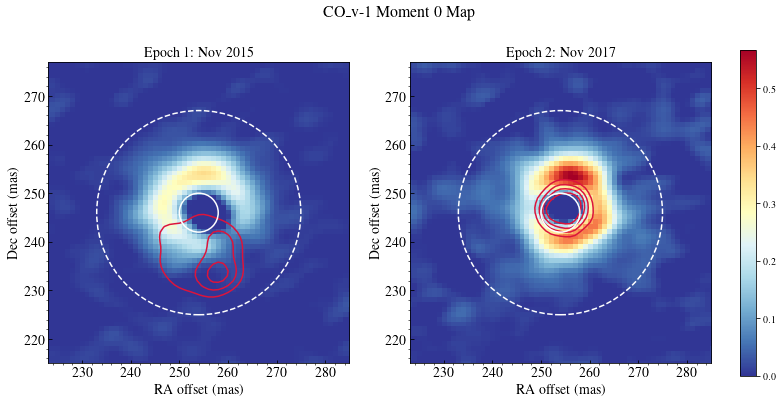

In [56]:
for mom in [0]: #, 1, 2, 8
    plot_mom_comparison('WHya_H2O.clean.imcontsub.image_mom0_chans51~84.fits',
                        'WHya_ep2_H2O.clean.imcontsub.image_mom0_chans51~84.fits',
                        inner_radius=4, outer_ap_radius=21, moment=mom)
    
    plot_mom_comparison('WHya_29SiO_v5.clean.imcontsub.image_mom0_chans48~83.fits',
                        'WHya_ep2_29SiO_v5.clean.imcontsub.image_mom0_chans48~83.fits',
                        inner_radius=4, outer_ap_radius=21, moment=mom)
    
    plot_mom_comparison('WHya_SiO_v2_larger_mask.clean.imcontsub.image_mom0_chans35~86.fits',
                        'WHya_ep2_SiO_v-2_larger_mask.clean.imcontsub.image_mom0_chans35~86.fits',
                        inner_radius=4, outer_ap_radius=21, moment=mom)
    
    plot_mom_comparison('WHya_SiO_v7.clean.imcontsub.image_mom0_chans48~81.fits',
                        'WHya_ep2_SiO_v7.clean.imcontsub.image_mom0_chans48~81.fits',
                        inner_radius=4, outer_ap_radius=21, moment=mom)
    
    plot_mom_comparison('WHya_CO_v-1.clean.imcontsub.image_mom0_chans52~82.fits',
                        'WHya_ep2_12CO_v-1.clean.imcontsub.image_mom0_chans52~82.fits',
                        inner_radius=4, outer_ap_radius=21, moment=mom)
    
    '''plot_mom_comparison('WHya_SO_3sigma0.clean.image_mom0_chans16~70.fits',
                        'WHya_ep2_SO_3sigma0.clean.image_mom0_chans16~70.fits',
                        inner_radius=4, outer_ap_radius=25, moment=mom)
    
    
    
    plot_mom_comparison('WHya_H13CN.clean.image_mom0_chans16~70.fits',
                        'WHya_ep2_H13CN.clean.image_mom0_chans16~70.fits',
                        inner_radius=4, outer_ap_radius=25, moment=mom)
    
    
    plot_mom_comparison('WHya_SiO_v-1.clean.image_mom0_chans16~70.fits',
                        'WHya_ep2_SiO_v-1.clean.image_mom0_chans16~70.fits',
                        inner_radius=4, outer_ap_radius=25, moment=mom)
    
    '''

In [42]:
"""epoch2_mom0 = []
epoch1_mom0 = []

hdu2 = fits.open(parent_dir + 'epoch2/' + 'WHya_ep2_H2O.clean.image_mom0_chans16~70.fits')
print(hdu.info())
data = hdu2[0].data
header = hdu2[0].header
    
epoch2_mom0.append(data)

hdu2.close()

hdu1 = fits.open(parent_dir + 'epoch1/' + 'WHya_H2O.clean.image_mom0_chans16~70.fits')
ep1_data = hdu1[0].data
epoch1_mom0.append(ep1_data)
#print(epoch2_mom0)

wcs1 = WCS(hdu1[0].header)
sky_coord = wcs1.pixel_to_world(1, 1, 30, 50)
sky_coord



for ep1_data, ep2_data in zip(epoch1_mom0, epoch2_mom0):
    print('Wtf')
    mean, median, std = sigma_clipped_stats(ep2_data)
    #fig, axes = plt.subplots(1, 2, figsize=(12,6), projection=wcs1)
    fig = plt.figure(figsize=(12,6))
    axes = []
    axes.append(fig.add_subplot(1, 2, 1, projection=wcs1[0,0]))
    axes.append(fig.add_subplot(1, 2, 2, projection=wcs1[0,0]))
    
    ep1_cont = axes[0].contour(ep1_data[0, 0, 205:305, 205:305], levels=np.logspace(-1.5, 2, 10), alpha=0.5)
    ep1_im = axes[0].imshow(ep1_data[0, 0, 205:305, 205:305], vmin=median-5*std, vmax=median+5*std,
                            cmap='Spectral_r')
    ep2_cont = axes[1].contour(ep2_data[0, 0, 205:305, 205:305], levels=np.logspace(-1.5, 2, 10), alpha=0.5)
    ep2_im = axes[1].imshow(ep2_data[0, 0, 205:305, 205:305], vmin=median-5*std, vmax=median+5*std,
                            cmap='Spectral_r')
    
    divider = make_axes_locatable(axes[1])
    #cax = divider.append_axes('right', size='10%', pad=0.5)
    plt.colorbar(ep1_im, ax=axes)#.ravel().tolist()
    
    axes[0].set_title('Epoch 1: Nov 2015')
    axes[1].set_title('Epoch 2: Nov 2017')
    #plt.suptitle('H$_2$O ')
    plt.savefig('../figures/mom0_comparison_h2o.png', dpi=300)
    
plt.show()"""

"epoch2_mom0 = []\nepoch1_mom0 = []\n\nhdu2 = fits.open(parent_dir + 'epoch2/' + 'WHya_ep2_H2O.clean.image_mom0_chans16~70.fits')\nprint(hdu.info())\ndata = hdu2[0].data\nheader = hdu2[0].header\n    \nepoch2_mom0.append(data)\n\nhdu2.close()\n\nhdu1 = fits.open(parent_dir + 'epoch1/' + 'WHya_H2O.clean.image_mom0_chans16~70.fits')\nep1_data = hdu1[0].data\nepoch1_mom0.append(ep1_data)\n#print(epoch2_mom0)\n\nwcs1 = WCS(hdu1[0].header)\nsky_coord = wcs1.pixel_to_world(1, 1, 30, 50)\nsky_coord\n\n\n\nfor ep1_data, ep2_data in zip(epoch1_mom0, epoch2_mom0):\n    print('Wtf')\n    mean, median, std = sigma_clipped_stats(ep2_data)\n    #fig, axes = plt.subplots(1, 2, figsize=(12,6), projection=wcs1)\n    fig = plt.figure(figsize=(12,6))\n    axes = []\n    axes.append(fig.add_subplot(1, 2, 1, projection=wcs1[0,0]))\n    axes.append(fig.add_subplot(1, 2, 2, projection=wcs1[0,0]))\n    \n    ep1_cont = axes[0].contour(ep1_data[0, 0, 205:305, 205:305], levels=np.logspace(-1.5, 2, 10), alpha=0.